In [1]:
#!/usr/bin/env python

# make sure to install necessary packages before running

import os
import sys
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sodapy import Socrata

# NYPD Arrest Data (Year to Date)
socrata_dataset_identifier = 'uip8-fykc'
socrata_domain = 'data.cityofnewyork.us'

# read application token
with open('app-token.txt', 'r') as fp:
    contents = fp.read()
socrata_token = contents

# connect to data
client = Socrata(socrata_domain, socrata_token)

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
#client = Socrata("data.cityofnewyork.us", None)

# Example authenticated client (needed for non-public datasets):
# client = Socrata('data.cityofnewyork.us',
#                  MyAppToken,
#                  username="user@example.com",
#                  password="AFakePassword")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
# results = client.get(socrata_dataset_identifier, limit=1000)

# Convert to pandas DataFrame
# results_df = pd.DataFrame.from_records(results)

In [2]:
# Metadata
metadata = client.get_metadata(socrata_dataset_identifier)
metadata_columns = [x['name'] for x in metadata['columns']]
metadata_columns

['ARREST_KEY',
 'ARREST_DATE',
 'PD_CD',
 'PD_DESC',
 'KY_CD',
 'OFNS_DESC',
 'LAW_CODE',
 'LAW_CAT_CD',
 'ARREST_BORO',
 'ARREST_PRECINCT',
 'JURISDICTION_CODE',
 'AGE_GROUP',
 'PERP_SEX',
 'PERP_RACE',
 'X_COORD_CD',
 'Y_COORD_CD',
 'Latitude',
 'Longitude']

In [3]:
# Metadata for a particular column
meta_arrest_date = [x for x in metadata['columns'] if x['name'] == 'ARREST_DATE'][0]
meta_arrest_date

{'id': 380202915,
 'name': 'ARREST_DATE',
 'dataTypeName': 'calendar_date',
 'description': 'Exact date of arrest for the reported event',
 'fieldName': 'arrest_date',
 'position': 2,
 'renderTypeName': 'calendar_date',
 'tableColumnId': 65692457,
 'cachedContents': {'largest': '2019-09-30T00:00:00.000',
  'non_null': 131043,
  'null': '0',
  'top': [{'item': '2019-05-02T00:00:00.000', 'count': '888'},
   {'item': '2019-04-17T00:00:00.000', 'count': '874'},
   {'item': '2019-01-10T00:00:00.000', 'count': '856'},
   {'item': '2019-01-23T00:00:00.000', 'count': '838'},
   {'item': '2019-07-24T00:00:00.000', 'count': '837'},
   {'item': '2019-04-03T00:00:00.000', 'count': '834'},
   {'item': '2019-04-10T00:00:00.000', 'count': '815'},
   {'item': '2019-04-24T00:00:00.000', 'count': '810'},
   {'item': '2019-08-14T00:00:00.000', 'count': '809'},
   {'item': '2019-01-03T00:00:00.000', 'count': '808'},
   {'item': '2019-03-13T00:00:00.000', 'count': '806'},
   {'item': '2019-05-01T00:00:00.0

In [4]:
# get date range of data
# note: string is returned
most_recent_date = meta_arrest_date['cachedContents']['largest']
oldest_date = meta_arrest_date['cachedContents']['smallest']
num_of_results = int(meta_arrest_date['cachedContents']['not_null'])
# print(most_recent_date)
# print(oldest_date)
print("Total number of not-null results: "+ str(num_of_results))

Total number of not-null results: 167965


In [5]:
# loop through the results

loop_size = 10000
num_loops = math.ceil(num_of_results/loop_size)

data = []

for i in range(num_loops):
    results = client.get(socrata_dataset_identifier, 
                         where="ARREST_DATE >= '2019-01-01T00:00:00.000'",
                         # select="column1,column2,etc",
                         # order="column1 ASC",
                         # can also do other operations 
                         limit=loop_size,
                         offset=loop_size * i)
    data.extend(results)
    #print("Loop number: " + str(i))

In [6]:
results_df = pd.DataFrame(data)

In [7]:
# what is law_cat_cd with value 'I'? Likely Traffic Infraction
results_df.loc[results_df['law_cat_cd'] == 'I'].head()

,age_group,arrest_boro,arrest_date,arrest_key,arrest_precinct,jurisdiction_code,ky_cd,latitude,law_cat_cd,law_code,longitude,ofns_desc,pd_cd,pd_desc,perp_race,perp_sex,x_coord_cd,y_coord_cd
480,25-44,M,2019-09-29T00:00:00.000,203019107,30,0,881.0,40.82902993600004,I,VTL1192AI1,-73.94483857899996,OTHER TRAFFIC INFRACTION,969,"TRAFFIC,UNCLASSIFIED INFRACTIO",BLACK,M,999516,241317
694,25-44,K,2019-09-29T00:00:00.000,203032026,75,0,880.0,40.64405022500005,I,VTL0509004,-73.87752086399996,MOVING INFRACTIONS,968,UNLICENSED OPERATOR,BLACK HISPANIC,M,1018240,173942
1132,25-44,K,2019-09-28T00:00:00.000,202990824,61,0,881.0,40.59406298000005,I,VTL060001A,-73.96086869299995,OTHER TRAFFIC INFRACTION,940,LEAVING THE SCENE / PROPERTY DAMAGE / INJURED ...,WHITE,M,995118,155709
1744,45-64,M,2019-09-27T00:00:00.000,202976260,14,0,881.0,40.75818729600008,I,VTL116000A,-73.98800312899994,OTHER TRAFFIC INFRACTION,969,"TRAFFIC,UNCLASSIFIED INFRACTIO",WHITE,M,987574,215502
2346,25-44,K,2019-09-26T00:00:00.000,202900508,77,0,881.0,40.669864569000026,I,VTL037502A,-73.95050361299997,OTHER TRAFFIC INFRACTION,969,"TRAFFIC,UNCLASSIFIED INFRACTIO",BLACK,M,997981,183327


In [8]:
results_df.describe()

,age_group,arrest_boro,arrest_date,arrest_key,arrest_precinct,jurisdiction_code,ky_cd,latitude,law_cat_cd,law_code,longitude,ofns_desc,pd_cd,pd_desc,perp_race,perp_sex,x_coord_cd,y_coord_cd
count,167965,167965,167965,167965,167965,167965,167848,167965,167003,167965,167965,167848,167930,167848,167965,167965,167965,167965
unique,5,5,273,167965,77,25,68,34148,4,1066,34149,64,265,253,7,2,27534,29121
top,25-44,K,2019-05-02T00:00:00.000,193535625,40,0,344.0,40.67998073800004,M,PL 1552500,-73.77623390699993,ASSAULT 3 & RELATED OFFENSES,101,ASSAULT 3,BLACK,M,1046315,187088
freq,89456,45842,888,1,5485,147043,24687,1285,99997,16757,1285,24687,19018,19018,80257,137135,1285,1286


In [9]:
# change arrest_boro abbreviation to long form
boro_dict = {
    'B': 'Bronx',
    'S': 'Staten Island',
    'K': 'Brooklyn',
    'M': 'Manhattan',
    'Q': 'Queens',
}
results_df['arrest_boro'] = results_df.arrest_boro.replace(boro_dict)

# change perp_sex abbreviation to long form
perp_sex_dict = {
    'F': 'Female',
    'M': 'Male'
}
results_df['perp_sex'] = results_df.perp_sex.replace(perp_sex_dict)


# change law_cat_cd abbreviation to long form
law_cat_cd_dict = {
    'F': 'Felony',
    'M': 'Misdemeanor',
    'V': 'Violation',
    'I': 'Traffic Infraction',
}
results_df['law_cat_cd'] = results_df['law_cat_cd'].replace(law_cat_cd_dict)

In [10]:
# change perp_race from all caps to title case
results_df['perp_race'] = results_df['perp_race'].apply(lambda x: x.title())

In [11]:
results_df.head()

,age_group,arrest_boro,arrest_date,arrest_key,arrest_precinct,jurisdiction_code,ky_cd,latitude,law_cat_cd,law_code,longitude,ofns_desc,pd_cd,pd_desc,perp_race,perp_sex,x_coord_cd,y_coord_cd
0,25-44,Manhattan,2019-09-30T00:00:00.000,203078287,9,0,105.0,40.72420015400007,Felony,PL 1600500,-73.97722564299994,ROBBERY,397,"ROBBERY,OPEN AREA UNCLASSIFIED",Black Hispanic,Male,990563,203120
1,18-24,Queens,2019-09-30T00:00:00.000,203072424,113,0,121.0,40.68997415500007,Felony,PL 1450502,-73.79676854399997,CRIMINAL MISCHIEF & RELATED OF,268,CRIMINAL MIS 2 & 3,Black,Male,1040611,190715
2,18-24,Staten Island,2019-09-30T00:00:00.000,203061215,122,0,347.0,40.60612948000005,Misdemeanor,VTL11920U3,-74.07657042999993,INTOXICATED & IMPAIRED DRIVING,905,"INTOXICATED DRIVING,ALCOHOL",White,Male,962989,160112
3,25-44,Staten Island,2019-09-30T00:00:00.000,203061218,120,0,105.0,40.645022746000045,Felony,PL 1601502,-74.077216847,ROBBERY,397,"ROBBERY,OPEN AREA UNCLASSIFIED",White Hispanic,Male,962822,174282
4,18-24,Queens,2019-09-30T00:00:00.000,203063729,106,0,105.0,40.68426580100004,Felony,PL 1601001,-73.81513849899994,ROBBERY,397,"ROBBERY,OPEN AREA UNCLASSIFIED",Asian / Pacific Islander,Male,1035521,188624


In [12]:
# unique arrest_boro
print(results_df.arrest_boro.unique())

# unique perp_sex
print()
print(results_df.perp_sex.unique())

# unique perp_race
print()
print(results_df.perp_race.unique())

# unique perp_race
print()
print(results_df['law_cat_cd'].value_counts())

# unique pd_desc
print()
unique_pd_desc = results_df.pd_desc.unique()
print(len(unique_pd_desc))

print()
print(results_df['arrest_boro'].value_counts())

print()
print(results_df['jurisdiction_code'].value_counts())

print()
print(results_df.shape)

print()
print(results_df.dtypes)

['Manhattan' 'Queens' 'Staten Island' 'Bronx' 'Brooklyn']

['Male' 'Female']

['Black Hispanic' 'Black' 'White' 'White Hispanic'
 'Asian / Pacific Islander' 'Unknown' 'American Indian/Alaskan Native']

Misdemeanor           99997
Felony                64303
Violation              2345
Traffic Infraction      358
Name: law_cat_cd, dtype: int64

254

Brooklyn         45842
Manhattan        41793
Bronx            38309
Queens           34864
Staten Island     7157
Name: arrest_boro, dtype: int64

0     147043
1       6729
2       6283
97      2579
3       2325
72       611
6        526
4        491
11       341
73       260
15       150
71       147
14       135
7        124
9         44
87        42
16        35
13        25
88        23
12        21
85        18
69         7
79         4
76         1
74         1
Name: jurisdiction_code, dtype: int64

(167965, 18)

age_group            object
arrest_boro          object
arrest_date          object
arrest_key           object
arrest_prec

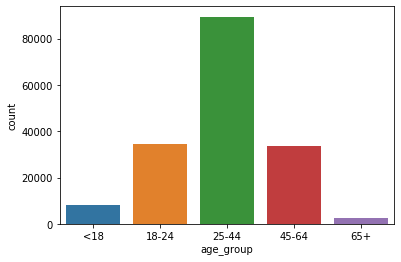

In [13]:
def order_labels(age_group_labels):
    """Returns age_group label sorted in ascending order"""
    ordered_labels = sorted(list(age_group_labels))
    last_item = ordered_labels.pop()
    ordered_labels.insert(0, last_item)
    return ordered_labels
    
age_group_labels = order_labels(results_df.age_group.unique())

sns.countplot(results_df['age_group'],
              order=age_group_labels)

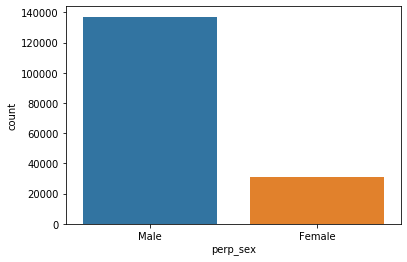

In [14]:
sns.countplot(results_df['perp_sex'],
              )

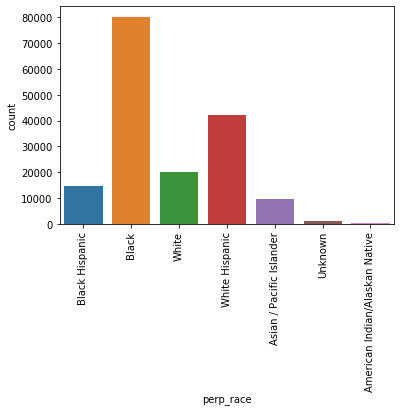

In [15]:
plot_race = sns.countplot(results_df['perp_race'],
             )
tick_labels = plot_race.get_xticklabels()
plot_race = plot_race.set_xticklabels(tick_labels, rotation=90)

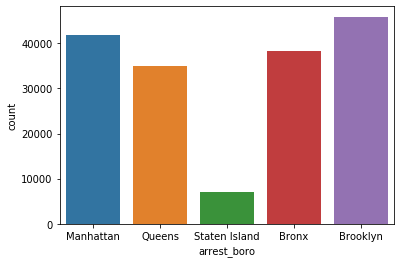

In [16]:
sns.countplot(results_df['arrest_boro'],
              )

In [17]:
# export Pandas DataFrame to csv
from datetime import date
today = date.today()

results_df.to_csv(f"{today}_nypd-arrests.csv", index_label="unique_id")